In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Basic Taxi Predictor")

<Experiment: artifact_location='/workspaces/MLOPSZoomCamp/03-exp-tracking/mlruns/1', creation_time=1733958842474, experiment_id='1', last_update_time=1733958842474, lifecycle_stage='active', name='Basic Taxi Predictor', tags={}>

In [4]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['trip duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['trip duration'] = df['trip duration'].apply(lambda x: x.total_seconds() / 60)

    dfClean = df[(df['trip duration'] >= 1) & (df['trip duration'] < 60)]

    categorical = ['PULocationID','DOLocationID']

    dfClean[categorical] = dfClean[categorical].astype(str)
    return df

In [5]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')
df_test = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet')

/tmp/ipykernel_21782/674562825.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfClean[categorical] = dfClean[categorical].astype(str)
/tmp/ipykernel_21782/674562825.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfClean[categorical] = dfClean[categorical].astype(str)


In [6]:
dv = DictVectorizer()
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

X_train = dv.fit_transform(df_train[categorical + numerical].to_dict(orient='records'))

X_val = dv.transform(df_test[categorical + numerical].to_dict(orient='records')) 

In [7]:
target = 'trip duration'
y_train = df_train[target].values
y_val = df_test[target].values

In [26]:
with mlflow.start_run():

    mlflow.set_tag("developer","blake")

    mlflow.log_param("train data", "January 2024 Yellow")
    mlflow.log_param("test data", "February 2024 Yellow")

    alpha = 0.01 
    mlflow.log_param("alpha", alpha)


    lr = Lasso(alpha)
    lr.fit(X_train,y_train)

    y_pred = lr.predict(X_val)

    mse = mean_squared_error(y_val,y_pred)
    mlflow.log_metric("mse", mse)

/tmp/ipykernel_21782/4165094070.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='predict')
/tmp/ipykernel_21782/4165094070.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label= 'actual')


<Axes: ylabel='Density'>

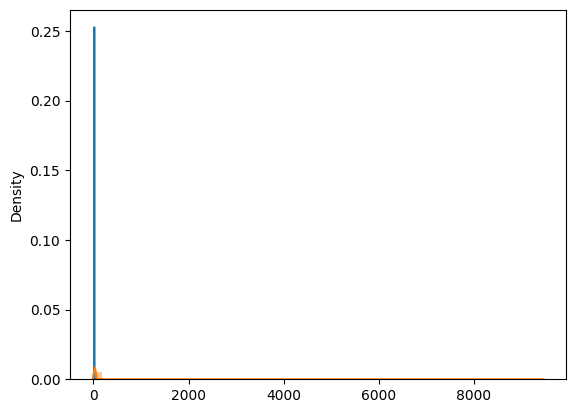

In [11]:
sns.distplot(y_pred, label='predict')
sns.distplot(y_train, label= 'actual')

In [20]:
with open('Models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)